<div class="markdown-google-sans">
  <h1>Welcome to Colab!</h1>
</div>

<div class="markdown-google-sans">
  <h2>&#40;New&#41; Try the Gemini API</h2>
  <ul>
  <li><a href="https://makersuite.google.com/app/apikey">Generate a Gemini API key</a></li>
  <li><a href="https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/Talk_to_Gemini_with_Google%27s_Speech_to_Text_API.ipynb?utm_medium=link&utm_campaign=gemini">Talk to Gemini with the Speech-to-Text API</a></li>
  <li><a href="https://colab.research.google.com/github/google/generative-ai-docs/blob/main/site/en/tutorials/quickstart_colab.ipynb?utm_medium=link&utm_campaign=gemini">Gemini API: Quickstart with Python</a></li>
  <li><a href="https://colab.research.google.com/notebooks/snippets/gemini.ipynb?utm_medium=link&utm_campaign=gemini">Gemini API code sample</a></li>
  <li><a href="https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/Learning_with_Gemini_and_ChatGPT.ipynb?utm_medium=link&utm_campaign=gemini">Compare Gemini with ChatGPT</a></li>  
  <li><a href="https://colab.google/notebooks/?utm_medium=link&utm_campaign=gemini">More notebooks</a></li>
  </ul>
</div>


In [7]:
import numpy as np # linear algebra
import pandas as pd

In [21]:
import re
from bs4 import BeautifulSoup
import string
import random
import spacy as sp
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [22]:
path_fake_data = "/Fake.csv"
path_true_data = "/True.csv"
fake_news = pd.read_csv(path_fake_data)
true_news = pd.read_csv(path_true_data)
fake_news.head()
true_news.head()
fake_news.info()
true_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [23]:
fake_news.duplicated().sum(), true_news.duplicated().sum()

(3, 206)

In [24]:
true_news.drop_duplicates(inplace=True)
fake_news.drop_duplicates(inplace=True)

In [25]:
true_news["target"] = 1
fake_news["target"] = 0

In [26]:
true_news.drop(["subject", "date", "title"], axis=1, inplace=True)
fake_news.drop(["subject", "date", "title"], axis=1, inplace=True)
total_news = 2000
fake_news = fake_news[:total_news]
true_news = true_news[:total_news]
news = pd.concat([true_news, fake_news], ignore_index=True)
news = news.sample(frac=1, random_state=42).reset_index(drop=True)
news.head()

,text,target
0,NEW YORK (Reuters) - Haitian immigrants on Tue...,1
1,Remember when Republicans were told to stop ta...,0
2,WASHINGTON (Reuters) - Republican Senator Rand...,1
3,Democratic National Committee Chairman Tom Per...,0
4,Republican Senator Rand Paul spoke with CNN s ...,0


In [27]:
nlp = sp.load("en_core_web_sm")
stop_words = sp.lang.en.STOP_WORDS

In [28]:
def preprocessing(text):
    text = BeautifulSoup(text, "lxml").get_text()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"[^a-zA-Z]", " ", text).strip()
    text = re.sub(r"  +", " ", text).strip()
    text = text.lower()
    doc = nlp(text)
    words = [token.text for token in doc if not token.is_stop and token.text not in string.punctuation]
    text = " ".join(words)

    return text

print(preprocessing(news["text"][1]))

sentences = list(news["text"])
labels = list(news["target"])
sentences = [preprocessing(sentence) for sentence in sentences]

remember republicans told stop talking rape repeatedly sticking foot mouths told stop talking attempt repeal affordable care act republicans giddily started preparing repeal landmark healthcare law faced sea angry constituents town hall events country gop dug heels strip healthcare millions americans voting base began realize healthcare threatened law referred obamacare wasn t bad fact realize law saved lives don t want republicans repeal lives jeopardy republicans shoved bill house reading getting cbo score bill lets states opt requiring insurance companies cover people pre existing conditions defined including sexual assault pregnancy cancer acne asthma diabetes sleep apnea alzheimer s disease host conditions medical problems list find pretty allow insurance companies discriminate millions americans conservatives included bill slashed billion medicaid covers millions low income americans order fund tax gift wealthy millions americans including conservatives red states got healthcare 

In [29]:
TRUNC='post'
PADDING = 'post'
OOV_TOKEN = "<OOV>"
EMBEDDING = 120
EPOCHS = 15
TRAINING_SPLIT = 0.8
maxlen = max([len(sentence.split()) for sentence in sentences])

In [20]:
def train_val_split(sentences, labels, training_split):
    """
    Splits the dataset into training and validation sets

    Args:
        sentences (list of string): lower-cased sentences without stopwords
        labels (list of string): list of labels
        training split (float): proportion of the dataset to convert to include in the train set

    Returns:
        train_sentences, validation_sentences, train_labels, validation_labels - lists containing the data splits
    """

    # Compute the number of sentences that will be used for training (should be an integer)
    train_size = int(len(sentences) * training_split)

    # Split the sentences and labels into train/validation splits
    train_sentences = sentences[:train_size]
    train_labels = labels[:train_size]

    validation_sentences = sentences[train_size:]
    validation_labels = labels[train_size:]

    return train_sentences, validation_sentences, train_labels, validation_labels

In [30]:
train_news, val_news, train_labels, val_labels = train_val_split(sentences, labels, TRAINING_SPLIT)

print(f"There are {len(train_news)} sentences for training.\n")
print(f"There are {len(train_labels)} labels for training.\n")
print(f"There are {len(val_news)} sentences for validation.\n")
print(f"There are {len(val_labels)} labels for validation.")

There are 3200 sentences for training.

There are 3200 labels for training.

There are 800 sentences for validation.

There are 800 labels for validation.


In [31]:
def fit_tokenizer(train_sentences, oov_token):

    # Instantiate the Tokenizer class, passing in the correct values for oov_token
    tokenizer = Tokenizer(oov_token=oov_token)

    # Fit the tokenizer to the training sentences
    tokenizer.fit_on_texts(train_sentences)

    return tokenizer

tokenizer = fit_tokenizer(sentences, OOV_TOKEN)
word_index = tokenizer.word_index
VOCAB_SIZE = len(word_index)

In [32]:
def seq_pad_and_trunc(sentences, tokenizer, padding, truncating, maxlen):
    """
    Generates an array of token sequences and pads them to the same length

    Args:
        sentences (list of string): list of sentences to tokenize and pad
        tokenizer (object): Tokenizer instance containing the word-index dictionary
        padding (string): type of padding to use
        truncating (string): type of truncating to use
        maxlen (int): maximum length of the token sequence

    Returns:
        pad_trunc_sequences (array of int): tokenized sentences padded to the same length
    """
    # Convert sentences to sequences
    sequences = tokenizer.texts_to_sequences(sentences)

    # Pad the sequences using the correct padding, truncating and maxlen
    pad_trunc_sequences = pad_sequences(sequences, padding=padding, truncating=truncating, maxlen=maxlen)

    return pad_trunc_sequences

train_pad_trunc_seq = seq_pad_and_trunc(train_news, tokenizer, PADDING, TRUNC, maxlen)
val_pad_trunc_seq = seq_pad_and_trunc(val_news, tokenizer, PADDING, TRUNC, maxlen)

print(f"Padded and truncated training sequences have shape: {train_pad_trunc_seq.shape}\n")
print(f"Padded and truncated validation sequences have shape: {val_pad_trunc_seq.shape}")

Padded and truncated training sequences have shape: (3200, 791)

Padded and truncated validation sequences have shape: (800, 791)


In [33]:
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

In [34]:
class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if logs.get('val_accuracy') is not None and logs.get('val_accuracy') >= 0.99:
                print("\nReached 99% val_accuracy so cancelling training!")
                # Stop training when the above condition is met
                self.model.stop_training = True

In [35]:
def create_model(vocab_size, embedding_dim, maxlen):
    """
    Creates a binary sentiment classifier model

    Args:
        vocab_size (int): size of the vocabulary for the Embedding layer input
        embedding_dim (int): dimensionality of the Embedding layer output
        maxlen (int): length of the input sequences
    Returns:
        model (tf.keras Model): the sentiment classifier model
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=maxlen),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [36]:
model = create_model(VOCAB_SIZE, EMBEDDING, maxlen)
callbacks = myCallback()

# Train the model and save the training history
history = model.fit(
    train_pad_trunc_seq, train_labels, epochs=EPOCHS,
    validation_data=(val_pad_trunc_seq, val_labels),
    callbacks=[callbacks]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.5194 - loss: 0.6931 - val_accuracy: 0.8238 - val_loss: 0.6659
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.6879 - loss: 0.6201 - val_accuracy: 0.9050 - val_loss: 0.2453
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9114 - loss: 0.2313 - val_accuracy: 0.9675 - val_loss: 0.0900
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.9685 - loss: 0.1030 - val_accuracy: 0.9825 - val_loss: 0.0548
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.9714 - loss: 0.0731 - val_accuracy: 0.9887 - val_loss: 0.0252
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9938 - loss: 0.0232
Reached 99% val_accuracy so cancelling training!
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.9938 - loss: 0.0231 - val_accuracy: 0.9900 - val_loss: 0.0224


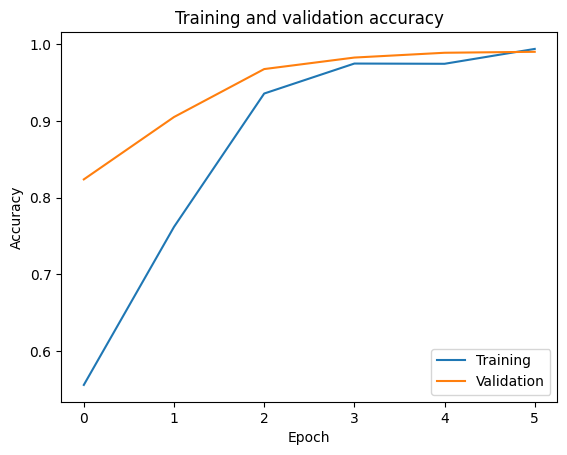

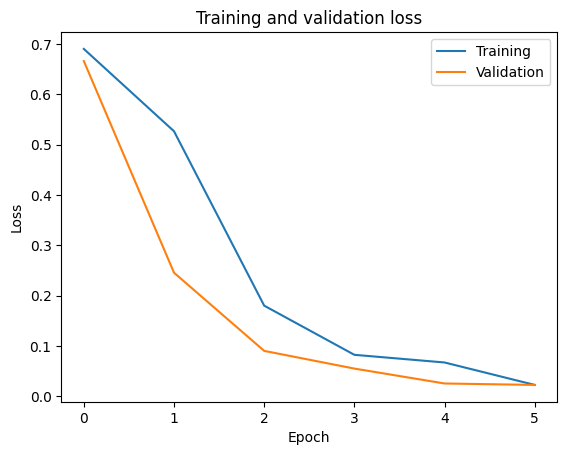

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(acc)
plt.plot(val_acc)
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

plt.plot(loss)
plt.plot(val_loss)
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()